In [11]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imgLoader as ld
from drawMap import drawMapGrid
from epipole import draw_epipolar_lines
import json
import math

%load_ext autoreload
%autoreload 2

OUTPUT_IMG_SIZE = [3600, 1800]

PLANET_RADIUS = 260
OM_RAD = 380.53
OM = [None, 
      [0, 0, +OM_RAD], 
      [0, 0, -OM_RAD], 
      [0, +OM_RAD, 0],
      [0, -OM_RAD, 0], 
      [+OM_RAD, 0, 0], 
      [-OM_RAD, 0, 0]]

PATH = "./images/"
PATH_PAIRS = "./pairs/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
img5, img5Meta = ld.readImg(PATH, "Cellin_5_cropped", "Cellin_5")
img6, img6Meta = ld.readImg(PATH, "Cellin_6_cropped", "Cellin_6")

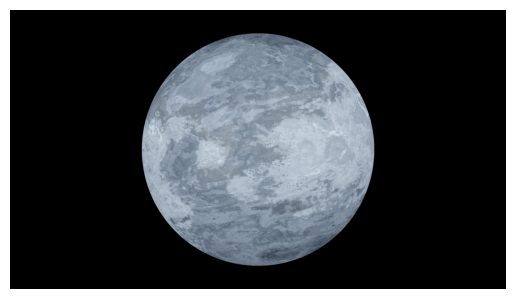

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": 593.7,
        "om2": null,
        "om3": 336.4,
        "om4": null,
        "om5": null,
        "om6": 310.2,
        "plt": 448.2
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 900
}


In [10]:
ld.showImg(img5)
ld.printMeta(img5Meta)

In [3]:
f = open(PATH_PAIRS + "5_6" + ".json")
pairs_5_6 = json.load(f)

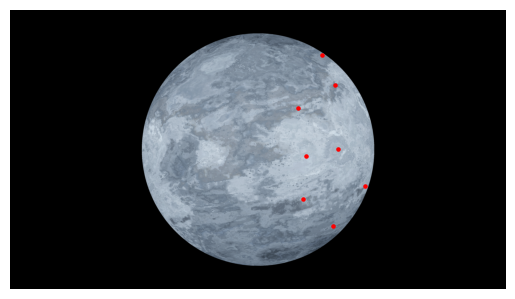

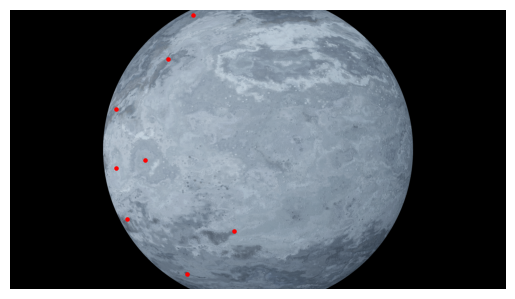

In [4]:
pt_5 = np.array(pairs_5_6["pt_5"])
pt_6 = np.array(pairs_5_6["pt_6"])
ld.showImgWithPts(img5, pt_5)
ld.showImgWithPts(img6, pt_6)

[[-1.27071347e-08  3.99275435e-07 -4.52788169e-04]
 [ 1.94558422e-07 -5.00397266e-08  8.32787336e-04]
 [-1.57367429e-04 -1.62308341e-03  1.00000000e+00]]


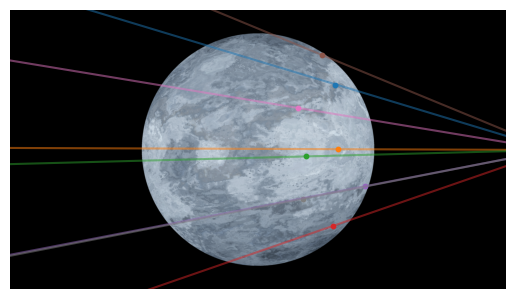

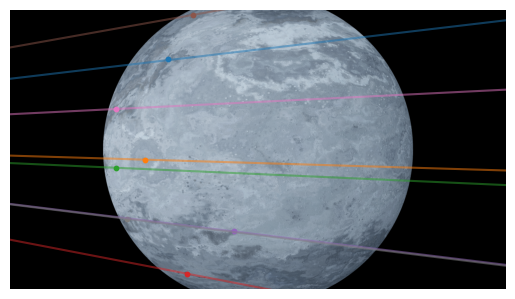

In [17]:
F65, mask = cv.findFundamentalMat(pt_5, pt_6, cv.FM_LMEDS)
F56 = F65.T
print(F56)

l = draw_epipolar_lines(img5, pt_6, pt_5, F56.T)
l = draw_epipolar_lines(img6, pt_5, pt_6, F56)

# Compute Essential Matrix

$$E = K_l^T F K_r$$

In [18]:
def computeK(maxU, maxV, fovU):
    # Compute Focal Length
    f = maxU / 2 / math.tan(math.radians(fovU / 2))
    
    K = np.array([[f,  0, maxU / 2],
                  [ 0, f, maxV / 2],
                  [ 0,  0,       1]])
    
    return K

In [35]:
# Computer Focal Length
K5 = computeK(img5.shape[1], img5.shape[0], img5Meta["fovU"])
K6 = computeK(img6.shape[1], img6.shape[0], img6Meta["fovU"])

E = K5.T @ F56 @ K6


In [36]:
print(E)

[[-0.02131204  0.66965316 -0.05953166]
 [ 0.32630773 -0.08392518  1.49228903]
 [ 0.03672517 -1.17917145  0.10114546]]


In [37]:
# Method from Hartley & Zisserman's book
U, S, Vt = np.linalg.svd(E)
W = np.array([[ 0, -1,  0],
              [+1,  0,  0],
              [ 0,  0, +1]])
Z = np.array([[ 0, +1,  0],
              [-1,  0,  0],
              [ 0,  0,  0]])
t = U @ Z @ U.T
R = U @ np.linalg.inv(W) @ Vt

print("t =")
print(t)
print("R =")
print(R)

t =
[[ 0.          0.49375883 -0.0012244 ]
 [-0.49375883  0.          0.86959802]
 [ 0.0012244  -0.86959802  0.        ]]
R =
[[-0.74454144 -0.00270351  0.66757077]
 [ 0.01362264 -0.9998451   0.01114418]
 [-0.66743724 -0.01739138 -0.74446294]]


In [45]:
t_x = t[2, 1]
t_y = t[0, 2]
t_z = t[1, 0]

t_norm = np.array([t_x, t_y, t_z]) / np.linalg.norm(np.array([t_x, t_y, t_z]))

### Validate the value

In [46]:
location5 = np.array([-327.78267271962784, 305.52303484613566, -8.926193861193727])
location6 = np.array(OM[6])

trans56 = location6 - location5
trans56_norm = trans56 / np.linalg.norm(trans56)

In [47]:
print(t_norm)
print(trans56_norm)

[-0.86959802 -0.0012244  -0.49375883]
[-0.17005866 -0.98501364  0.02877826]
